## Installing Tensorflow Decision forest 

TensorFlow Decision Forests (TF-DF) is a collection of state-of-the-art algorithms for the training, serving and interpretation of Decision Forest models. The library is a collection of Keras models and supports classification, regression and ranking.

TF-DF is a wrapper around the Yggdrasil Decision Forest C++ libraries. Models trained with TF-DF are compatible with Yggdrasil Decision Forests' models, and vice versa.

In [ ]:
!pip3 install tensorflow_decision_forests --upgrade
!pip install wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.0 MB 545 kB/s 
     |████████████████████████████████| 511.7 MB 6.9 kB/s 
     |████████████████████████████████| 1.6 MB 55.2 MB/s 
     |████████████████████████████████| 438 kB 75.0 MB/s 
     |████████████████████████████████| 5.8 MB 47.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

### Importing all the important libraries and modules 

In [ ]:
import os
import numpy as np
import tensorflow_decision_forests as tfdf
import pandas as pd
import urllib.request
from datetime import datetime
!pip install mne
import mne

def to_timestamp(x: str, acq_time: datetime):
    date = datetime.strptime(x, '%H:%M:%S')
    date = datetime(acq_time.year, acq_time.month, acq_time.day, date.hour, date.minute, date.second)
    if date.hour < 12:
        date = datetime(date.year, date.month, date.day + 1, date.hour, date.minute, date.second)
    return (date.day - acq_time.day) * 24 * 3600 + (date.hour - acq_time.hour) * 3600 + (
                date.minute - acq_time.minute) * 60 + date.second - acq_time.second


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 8.2 MB/s 


### Defining the subsample function for the data

Subsampling is a statistical method for selecting a subset of a larger data set. The subset is a representation of the larger data set. If a data set is too large to fit in memory, a subsample representing the larger data set must be chosen.

Subsampling accelerates the training of machine learning models. A subsample of the data can be used because training a machine learning model on a large data set takes time. This is useful when the data set is too large to fit in memory.

In [ ]:
def subsample(data: np.ndarray, fs: int, fs_new: int, axis=0):
    assert fs % fs_new == 0
    factor = int(fs / fs_new)
    if data.shape[axis] % factor != 0: 
        print('Subsampling led to loss of %i samples, in an online setting consider using a BlockBuffer with a '
              'buffer size of a multiple of %i samples.' % (data.shape[axis] % factor, factor))
    idx_mask = np.arange(data.shape[axis], step=factor)
    return data.take(idx_mask, axis)

### Defining the functions for following:

1. Reading the annotations file
2. Merging the data file and annotations file

In [ ]:
def read_annotation_file(path_filename: str, acq_time: datetime):
    df_annotations_data = pd.read_csv(path_filename, sep='\t', skiprows=20)
    df_annotations_data = df_annotations_data.loc[df_annotations_data["Event"].str.startswith("SLEEP")]
    df_annotations_data = df_annotations_data.rename(columns={"Time [hh:mm:ss]": "onset", "Duration[s]": "duration"})
    df_annotations_data["timestamp"] = df_annotations_data.onset.apply(lambda x: to_timestamp(x, acq_time))

    return df_annotations_data


def merge_data_file_and_annotations(data, df_annotations, fs_new):
    raw_data = data.get_data()
    fs = int(data.info["sfreq"])
    df = pd.DataFrame(raw_data.T, columns=data.info.ch_names)
    df["times"] = data.times
    df = pd.DataFrame(data=subsample(df.to_numpy(), fs, fs_new), columns=df.columns)
    
    labels = [np.nan] * df.shape[0]
    for i in range(df_annotations.shape[0] - 1):
        row_start = df_annotations.iloc[i]
        row_end = df_annotations.iloc[i + 1]
        start_pos = row_start.timestamp * fs_new
        end_pos = row_end.timestamp * fs_new
        if start_pos < len(labels):
            labels[start_pos:end_pos] = [row_start["Sleep Stage"]]*(end_pos-start_pos)
    
    df["sleepstage"] = labels
    df = df.dropna()
    
    return df

### Downloading and importing the data into directories

In [ ]:
# Subject ID
subject_name = 'rbd1'
# New frequency
fs_new = 128
# CSV Filename
new_filename = f'{subject_name}_data_and_annotations.csv'
              
data_filename = f'{subject_name}.edf'
filename_annotations = f'{subject_name}_annotations.txt'
url_data = f'https://physionet.org/files/capslpdb/1.0.0/{subject_name}.edf?download'
url_annotations = f'https://physionet.org/files/capslpdb/1.0.0/{subject_name}.txt?download'

print(f'Downloading data file: {url_data}')
urllib.request.urlretrieve(url_data, data_filename)

print(f'Downloading annotations data file: {url_annotations}')
urllib.request.urlretrieve(url_annotations, filename_annotations)


print(f'Loading File: {data_filename}')
data_polysomnography = mne.io.read_raw_edf(data_filename)

print(f'Loading Annotations file: {filename_annotations}')
df_annotations_polysomnography = read_annotation_file(filename_annotations, data_polysomnography.info["meas_date"])

print("\n\n Example Annotations file: \n")
df_annotations_polysomnography.head(4)

Loading File: rbd1.edf
Extracting EDF parameters from /content/rbd1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Loading Annotations file: rbd1_annotations.txt


 Example Annotations file: 



,Sleep Stage,Position,onset,Event,duration,Location,timestamp
0,W,Unknown Position,23:07:19,SLEEP-S0,30,ROC-LOC,9270
1,W,Unknown Position,23:07:49,SLEEP-S0,30,ROC-LOC,9300
2,W,Unknown Position,23:08:19,SLEEP-S0,30,ROC-LOC,9330
3,W,Unknown Position,23:08:49,SLEEP-S0,30,ROC-LOC,9360


In [ ]:
df_annotations_polysomnography.tail()

,Sleep Stage,Position,onset,Event,duration,Location,timestamp
927,R,Unknown Position,04:54:49,SLEEP-REM,30,ROC-LOC,30120
928,R,Unknown Position,04:55:19,SLEEP-REM,30,ROC-LOC,30150
929,W,Unknown Position,04:55:49,SLEEP-S0,30,ROC-LOC,30180
930,W,Unknown Position,04:56:19,SLEEP-S0,30,ROC-LOC,30210
931,W,Unknown Position,04:56:49,SLEEP-S0,30,ROC-LOC,30240


In [ ]:
print(f'Merge files annotation and polysomnography data. Downsampling data from {data_polysomnography.info["sfreq"]} to {fs_new} Hz')

Merge files annotation and polysomnography data. Downsampling data from 512.0 to 128 Hz


### Merging the data of both annotation and data file

In [ ]:
df_data = merge_data_file_and_annotations(data_polysomnography, df_annotations_polysomnography, fs_new)
df_data.to_csv(new_filename, index=False)
print("Data Merged")

df_data.head(4)

Data Merged


,ROC-LOC,Fp2-F4,F4-C4,C4-P4,P4-O2,C4-A1,EMG1-EMG2,ECG1-ECG2,DX1-DX2,SX1-SX2,F8-T4,F7-T3,TORACE,ADDOME,MIC,times,sleepstage
1186560,-0.000021,2.304640e-06,6.868132e-07,2.594628e-07,1.984127e-07,-0.000009,0.000005,-0.000032,5.799756e-07,4.273504e-07,6.715507e-07,0.000005,0.000299,-0.000792,-3.803311e-06,9270.000000,W
1186561,-0.000023,1.266789e-06,2.274115e-06,4.578755e-08,1.678877e-07,-0.000006,0.000003,-0.000167,5.189255e-07,-1.526252e-07,-9.157509e-07,0.000010,0.000360,-0.000862,1.392386e-06,9270.007812,W
1186562,-0.000021,-1.678877e-07,1.633089e-06,5.647131e-07,3.205128e-07,0.000002,-0.000001,-0.000352,-4.884005e-07,-6.410256e-07,-6.715507e-07,0.000004,0.000295,-0.000809,4.959182e-08,9270.015625,W
1186563,-0.000019,1.236264e-06,1.205739e-06,1.877289e-06,6.257631e-07,0.000007,-0.000004,-0.000383,-2.442002e-07,3.970467e-23,1.923077e-06,-0.000015,0.000259,-0.000783,-3.917754e-06,9270.023438,W


In [ ]:
df_data.tail()

,ROC-LOC,Fp2-F4,F4-C4,C4-P4,P4-O2,C4-A1,EMG1-EMG2,ECG1-ECG2,DX1-DX2,SX1-SX2,F8-T4,F7-T3,TORACE,ADDOME,MIC,times,sleepstage
3870715,-0.000005,-0.000002,-7.783883e-07,-7.173382e-07,0.000009,0.000002,-1.922763e-06,-0.000013,4.273504e-07,-1.905824e-21,-3.052503e-07,1.526252e-06,0.000876,0.000432,-3.700313e-07,30239.960938,W
3870716,-0.000003,-0.000002,-1.388889e-06,-7.478632e-07,0.000009,-0.000002,6.104010e-07,-0.000019,4.273504e-07,-4.578755e-07,4.884005e-07,3.357753e-07,0.000675,0.000477,-1.308461e-06,30239.968750,W
3870717,-0.000003,-0.000002,-1.785714e-06,-1.816239e-06,0.000007,-0.000005,-5.585169e-06,0.000001,4.578755e-07,-6.105006e-08,4.578755e-07,-1.831502e-07,0.000353,0.000562,-1.819638e-06,30239.976562,W
3870718,-0.000004,-0.000002,-2.335165e-06,-2.518315e-06,0.000006,-0.000005,2.838365e-06,0.000018,-3.357753e-07,2.442002e-07,-7.326007e-07,-3.021978e-06,0.000558,0.000473,3.471427e-07,30239.984375,W
3870719,-0.000005,-0.000001,-2.121490e-06,-1.907814e-06,0.000006,-0.000003,-7.935213e-07,0.000016,-5.494505e-07,-6.105006e-08,3.663004e-07,-2.777778e-06,0.001477,0.000158,2.338445e-06,30239.992188,W


### Visualizing the data

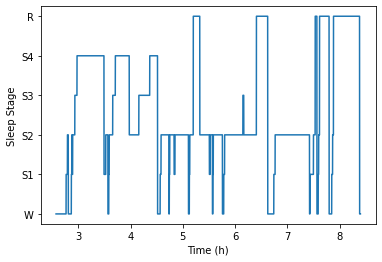

In [ ]:
import matplotlib.pyplot as plt
_ = plt.plot(df_data.times/3600, df_data.sleepstage)
_ = plt.xlabel("Time (h)")
_ = plt.ylabel("Sleep Stage")

In [ ]:
import os
import numpy as np
import pandas as pd
import urllib.request
from datetime import datetime
import mne

df = pd.read_csv(new_filename)
df.head(4)

,ROC-LOC,Fp2-F4,F4-C4,C4-P4,P4-O2,C4-A1,EMG1-EMG2,ECG1-ECG2,DX1-DX2,SX1-SX2,F8-T4,F7-T3,TORACE,ADDOME,MIC,times,sleepstage
0,-0.000021,2.304640e-06,6.868132e-07,2.594628e-07,1.984127e-07,-0.000009,0.000005,-0.000032,5.799756e-07,4.273504e-07,6.715507e-07,0.000005,0.000299,-0.000792,-3.803311e-06,9270.000000,W
1,-0.000023,1.266789e-06,2.274115e-06,4.578755e-08,1.678877e-07,-0.000006,0.000003,-0.000167,5.189255e-07,-1.526252e-07,-9.157509e-07,0.000010,0.000360,-0.000862,1.392386e-06,9270.007812,W
2,-0.000021,-1.678877e-07,1.633089e-06,5.647131e-07,3.205128e-07,0.000002,-0.000001,-0.000352,-4.884005e-07,-6.410256e-07,-6.715507e-07,0.000004,0.000295,-0.000809,4.959182e-08,9270.015625,W
3,-0.000019,1.236264e-06,1.205739e-06,1.877289e-06,6.257631e-07,0.000007,-0.000004,-0.000383,-2.442002e-07,3.970467e-23,1.923077e-06,-0.000015,0.000259,-0.000783,-3.917754e-06,9270.023438,W


### Visualizing the data for following:

1. Times
2. ROC-LOC
3. F4-C4

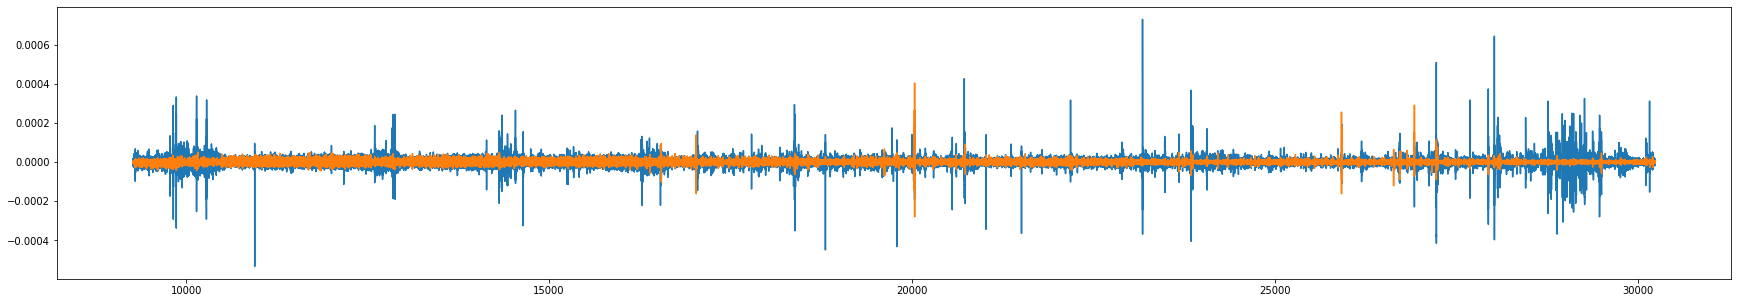

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (30,5))
plt.plot(df["times"], df["ROC-LOC"])
plt.plot(df["times"], df["F4-C4"])
#plt.plot(df["times"], df["sleepstage"])

In [ ]:
df.columns

Index(['ROC-LOC', 'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'C4-A1', 'EMG1-EMG2',
       'ECG1-ECG2', 'DX1-DX2', 'SX1-SX2', 'F8-T4', 'F7-T3', 'TORACE', 'ADDOME',
       'MIC', 'times', 'sleepstage'],
      dtype='object')

### Applying the MinMaxScaler on the data

Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

In [ ]:
#sklearn.preprocessing.MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


new_df = df.iloc[:,:-2]
new_df.head(4)
print(scaler.fit(new_df))

print(scaler.data_max_)
df_norm = scaler.transform(new_df)
df_norm = pd.DataFrame(df_norm)
df_norm['times'] = df['times']
df_norm['sleepstage'] = df['sleepstage']
df_norm.head(4)

MinMaxScaler()
[7.28980075e-04 4.52274115e-04 4.03586691e-04 4.44001832e-04
 3.66071429e-04 3.62652625e-04 5.91173393e-04 9.21369060e-04
 3.77960928e-04 3.53663004e-04 8.42185592e-04 7.52106227e-04
 5.98955156e-03 6.06275699e-03 8.99481193e-05]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,times,sleepstage
0,0.405702,0.690211,0.410654,0.502975,0.615501,0.594384,0.528498,0.503567,0.425484,0.470777,0.530494,0.459260,0.527172,0.426842,0.353739,9270.000000,W
1,0.404493,0.689496,0.412976,0.502735,0.615469,0.598248,0.527198,0.433279,0.425392,0.469908,0.529608,0.462576,0.532224,0.420962,0.389555,9270.007812,W
2,0.405557,0.688509,0.412038,0.503316,0.615629,0.606675,0.523542,0.337109,0.423858,0.469176,0.529744,0.458199,0.526893,0.425437,0.380299,9270.015625,W
3,0.407419,0.689475,0.411413,0.504787,0.615950,0.612105,0.521506,0.320761,0.424230,0.470136,0.531192,0.444228,0.523863,0.427642,0.352950,9270.023438,W


#### Visualzing the transformed data

In [ ]:
df_norm.columns = df.columns 

df_sel = df_norm[['ROC-LOC', 'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'C4-A1', 'EMG1-EMG2','ECG1-ECG2', 'DX1-DX2', 'SX1-SX2', 'F8-T4', 'F7-T3', 'TORACE', 'ADDOME',
                  'MIC', 'times', 'sleepstage']]
df.head(4)

,ROC-LOC,Fp2-F4,F4-C4,C4-P4,P4-O2,C4-A1,EMG1-EMG2,ECG1-ECG2,DX1-DX2,SX1-SX2,F8-T4,F7-T3,TORACE,ADDOME,MIC,times,sleepstage
0,-0.000021,2.304640e-06,6.868132e-07,2.594628e-07,1.984127e-07,-0.000009,0.000005,-0.000032,5.799756e-07,4.273504e-07,6.715507e-07,0.000005,0.000299,-0.000792,-3.803311e-06,9270.000000,W
1,-0.000023,1.266789e-06,2.274115e-06,4.578755e-08,1.678877e-07,-0.000006,0.000003,-0.000167,5.189255e-07,-1.526252e-07,-9.157509e-07,0.000010,0.000360,-0.000862,1.392386e-06,9270.007812,W
2,-0.000021,-1.678877e-07,1.633089e-06,5.647131e-07,3.205128e-07,0.000002,-0.000001,-0.000352,-4.884005e-07,-6.410256e-07,-6.715507e-07,0.000004,0.000295,-0.000809,4.959182e-08,9270.015625,W
3,-0.000019,1.236264e-06,1.205739e-06,1.877289e-06,6.257631e-07,0.000007,-0.000004,-0.000383,-2.442002e-07,3.970467e-23,1.923077e-06,-0.000015,0.000259,-0.000783,-3.917754e-06,9270.023438,W


### Making the dataset excluding the columns of times, sleepstage

In [ ]:
columns_electrodes = [el for el in df_sel.columns if el not in ["times", "sleepstage"]]
columns_electrodes

['ROC-LOC',
 'Fp2-F4',
 'F4-C4',
 'C4-P4',
 'P4-O2',
 'C4-A1',
 'EMG1-EMG2',
 'ECG1-ECG2',
 'DX1-DX2',
 'SX1-SX2',
 'F8-T4',
 'F7-T3',
 'TORACE',
 'ADDOME',
 'MIC']

#### Puting Sleep Stage Ids accordingly and visualizing

In [ ]:
# Conversion sleep stages to Id's
sleep_stages_ids = {"W": 0, "S1": 0, "S2": 0, "S3":0, "S4":0, "R": 1}
sleep_stages_parsed = df["sleepstage"].apply(lambda x: sleep_stages_ids[x])

# Convert the sleep stage to ID's
df_sel["sleepstage"] = sleep_stages_parsed

df_sel.head(10)

,ROC-LOC,Fp2-F4,F4-C4,C4-P4,P4-O2,C4-A1,EMG1-EMG2,ECG1-ECG2,DX1-DX2,SX1-SX2,F8-T4,F7-T3,TORACE,ADDOME,MIC,times,sleepstage
0,0.405702,0.690211,0.410654,0.502975,0.615501,0.594384,0.528498,0.503567,0.425484,0.470777,0.530494,0.459260,0.527172,0.426842,0.353739,9270.000000,0
1,0.404493,0.689496,0.412976,0.502735,0.615469,0.598248,0.527198,0.433279,0.425392,0.469908,0.529608,0.462576,0.532224,0.420962,0.389555,9270.007812,0
2,0.405557,0.688509,0.412038,0.503316,0.615629,0.606675,0.523542,0.337109,0.423858,0.469176,0.529744,0.458199,0.526893,0.425437,0.380299,9270.015625,0
3,0.407419,0.689475,0.411413,0.504787,0.615950,0.612105,0.521506,0.320761,0.424230,0.470136,0.531192,0.444228,0.523863,0.427642,0.352950,9270.023438,0
4,0.410442,0.689623,0.411859,0.506223,0.617554,0.612838,0.520671,0.443304,0.424741,0.469587,0.531873,0.444781,0.526550,0.424120,0.370990,9270.031250,0
5,0.412207,0.689959,0.412261,0.506941,0.618869,0.612438,0.525088,0.540887,0.424834,0.470959,0.530494,0.449246,0.528323,0.421526,0.403334,9270.039062,0
6,0.410756,0.687962,0.410163,0.506941,0.618805,0.618467,0.527370,0.569025,0.423858,0.470136,0.530630,0.457801,0.526183,0.422892,0.367624,9270.046875,0
7,0.408701,0.686975,0.406457,0.507112,0.619478,0.619133,0.524695,0.553312,0.424880,0.469953,0.529131,0.458110,0.524507,0.423811,0.391343,9270.054688,0
8,0.409281,0.686407,0.404358,0.507795,0.621211,0.620499,0.528744,0.531530,0.425020,0.469450,0.529557,0.455635,0.525752,0.421791,0.375986,9270.062500,0
9,0.411240,0.685987,0.406144,0.508719,0.621916,0.626262,0.522291,0.517469,0.424323,0.471371,0.530834,0.459171,0.526673,0.420095,0.398548,9270.070312,0


### Visualizing the data 

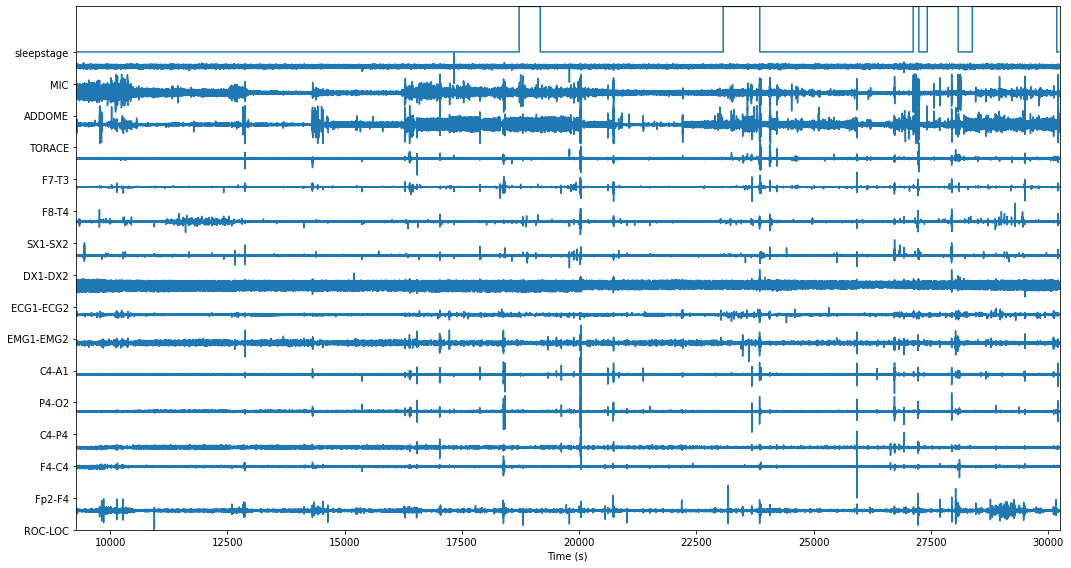

In [ ]:
import matplotlib.pyplot as plt

fs = int(1/(df_sel.times[1] - df_sel.times[0]))

# Number of points to plot per second, in this case all the points are being ploted
number_points_1_sec = 10/fs
marker_every_sec = int(number_points_1_sec*fs)
indexes_plot = np.arange(0, df.shape[0], marker_every_sec)

def plot_multiple(df_data, columns_plot, ax2, markevery=1):
  """
  This function receives a dataframe, the column names that one desires to plot 
  and the Axes plot
  """

  plt_columns = columns_plot.copy()
  # Plot also sleep stage
  plt_columns.append("sleepstage")

  n_rows = len(plt_columns)
  dmin = df_data[plt_columns].min().min()
  dmax = df_data[plt_columns].max().max()
  dr = (dmax - dmin) * 0.7  # Crowd them a bit.
  y0 = dmin
  y1 = (n_rows - 1) * dr + dmax
  ax2.set_ylim(y0, y1)
  ticklocs=[]
  segs = []
  ax2.set_xlim([df_data.times.min(), df_data.times.max()])
  ax2.set_ylim(y0, y1)

  for i, column_name in enumerate(plt_columns):
      segs.append(df_data.iloc[np.arange(0, df_data.shape[0], markevery)][["times", column_name]])
      ticklocs.append(i * dr)
  

  offsets = np.zeros((n_rows, 2), dtype=float)
  offsets[:, 1] = ticklocs

  lines = LineCollection(segs, offsets=offsets, transOffset=None)
  ax2.add_collection(lines)

  # Set the yticks to use axes coordinates on the y axis
  _ = ax2.set_yticks(ticklocs)
  # Set the yticks to use axes coordinates on the y axis
  ax2.set_yticks(ticklocs)
  ax2.set_yticklabels(plt_columns)

  ax2.set_xlabel('Time (s)')
  
from matplotlib.collections import LineCollection

f, ax_multiple = plt.subplots(1, 1, figsize=(15, 8)) 
plot_multiple(df_sel, columns_electrodes, ax_multiple, markevery=marker_every_sec)

plt.tight_layout()
plt.show()

### Implementation of FastICA 
A fast algorithm for Independent Component Analysis.

In [ ]:
from sklearn.decomposition import FastICA
ica_model = FastICA(n_components=len(columns_electrodes), random_state=0)

# Apply ICA only to the electrodes (exclude sleep stages and times)
independent_sources = ica_model.fit_transform(df_sel[columns_electrodes])

# Apply the Min-Max Scaler
scaled_independent_sources = MinMaxScaler().fit_transform(independent_sources)*df_sel["sleepstage"].max()

# The fit_transform returns a matrix, convert it to dataframe
components_columns_name = [f'component#{el}' for el in range(len(columns_electrodes))]
print(components_columns_name)
print("Modified DataFrame:")
df_sources = pd.DataFrame(data=scaled_independent_sources, columns=components_columns_name)
df_sources["times"] = df_sel["times"]
df_sources["sleepstage"] = df_sel["sleepstage"]
df_sources.head(4)

['component#0', 'component#1', 'component#2', 'component#3', 'component#4', 'component#5', 'component#6', 'component#7', 'component#8', 'component#9', 'component#10', 'component#11', 'component#12', 'component#13', 'component#14']
Modified DataFrame:


,component#0,component#1,component#2,component#3,component#4,component#5,component#6,component#7,component#8,component#9,component#10,component#11,component#12,component#13,component#14,times,sleepstage
0,0.495620,0.406276,0.561871,0.433764,0.470621,0.574675,0.459297,0.363239,0.407139,0.530053,0.310249,0.502493,0.528269,0.644890,0.501301,9270.000000,0
1,0.503015,0.406937,0.562276,0.426839,0.469897,0.574761,0.463498,0.363915,0.409506,0.529039,0.311314,0.432443,0.527493,0.608303,0.502864,9270.007812,0
2,0.500179,0.410681,0.562067,0.429775,0.469350,0.576169,0.460321,0.363862,0.408753,0.528872,0.312516,0.335989,0.524712,0.616330,0.505906,9270.015625,0
3,0.497373,0.412995,0.561461,0.430587,0.470312,0.575652,0.446574,0.363475,0.406921,0.530065,0.311514,0.319356,0.523043,0.643482,0.510979,9270.023438,0


In [ ]:
print(components_columns_name)
components_columns_name.append('times')

['component#0', 'component#1', 'component#2', 'component#3', 'component#4', 'component#5', 'component#6', 'component#7', 'component#8', 'component#9', 'component#10', 'component#11', 'component#12', 'component#13', 'component#14']


In [ ]:
print(components_columns_name)

['component#0', 'component#1', 'component#2', 'component#3', 'component#4', 'component#5', 'component#6', 'component#7', 'component#8', 'component#9', 'component#10', 'component#11', 'component#12', 'component#13', 'component#14', 'times']


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df_sources[components_columns_name] = scaler.fit_transform(df_sources[components_columns_name])

In [ ]:
df_sources.head()

,component#0,component#1,component#2,component#3,component#4,component#5,component#6,component#7,component#8,component#9,component#10,component#11,component#12,component#13,component#14,times,sleepstage
0,0.495620,0.406276,0.561871,0.433764,0.470621,0.574675,0.459297,0.363239,0.407139,0.530053,0.310249,0.502493,0.528269,0.644890,0.501301,0.000000e+00,0
1,0.503015,0.406937,0.562276,0.426839,0.469897,0.574761,0.463498,0.363915,0.409506,0.529039,0.311314,0.432443,0.527493,0.608303,0.502864,3.725562e-07,0
2,0.500179,0.410681,0.562067,0.429775,0.469350,0.576169,0.460321,0.363862,0.408753,0.528872,0.312516,0.335989,0.524712,0.616330,0.505906,7.451123e-07,0
3,0.497373,0.412995,0.561461,0.430587,0.470312,0.575652,0.446574,0.363475,0.406921,0.530065,0.311514,0.319356,0.523043,0.643482,0.510979,1.117669e-06,0
4,0.496819,0.413220,0.561477,0.425692,0.469518,0.575270,0.445673,0.362915,0.405930,0.531043,0.310895,0.441899,0.521174,0.627057,0.521385,1.490225e-06,0


In [ ]:
df_sources.isnull().any().values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [ ]:
lt=  ['component#0', 'component#1', 'component#3', 'component#4', 'component#7','component#8', 'component#9','component#10','component#11','component#12','component#13','component#14' ]

In [ ]:
df_sourcess = df_sources.drop(lt,axis=1)
df_sourcess.head()

,component#2,component#5,component#6,times,sleepstage
0,0.561871,0.574675,0.459297,0.000000e+00,0
1,0.562276,0.574761,0.463498,3.725562e-07,0
2,0.562067,0.576169,0.460321,7.451123e-07,0
3,0.561461,0.575652,0.446574,1.117669e-06,0
4,0.561477,0.575270,0.445673,1.490225e-06,0


In [ ]:
x = df_sourcess.drop("sleepstage",axis=1)
y = df_sourcess["sleepstage"]

In [ ]:

y.unique()


array([0, 1])

In [ ]:

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size = 0.9,stratify=y)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2415744, 4)
(268416, 4)
(2415744,)
(268416,)


In [ ]:
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB



In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# **Applying Navie Bayes classification**

Naive Bayes test accuracy score:  0.9020363912732475
Naive Bayes train accuracy score:  0.9027285175912679


Text(69.0, 0.5, 'Truth')

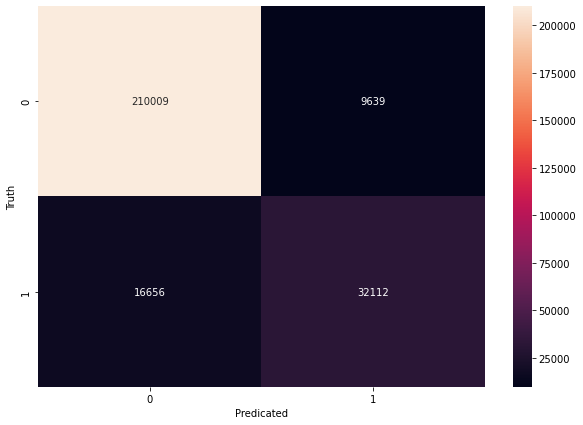

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf

nb= GaussianNB()
nb.fit(x_train, y_train)
print("Naive Bayes test accuracy score: ",nb.score(x_test, y_test))
print("Naive Bayes train accuracy score: ",nb.score(x_train, y_train))

preds5 = nb.predict(x_test)
cm = tf.math.confusion_matrix(labels=y_test,predictions=preds5)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicated')
plt.ylabel('Truth')

# **Applying logistic regression**

logistic regression test accuracy score:  0.9152844837863615
logistic regression train accuracy score:  0.9155535520320034


Text(69.0, 0.5, 'Truth')

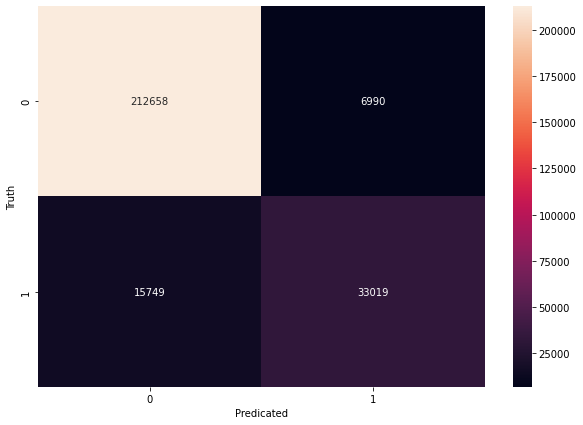

In [ ]:
from sklearn.linear_model import LogisticRegression
model3 = LogisticRegression()
model3.fit(x_train, y_train)

print("logistic regression test accuracy score: ",model3.score(x_test, y_test))
print("logistic regression train accuracy score: ",model3.score(x_train, y_train))

preds3 = model3.predict(x_test)
cm = tf.math.confusion_matrix(labels=y_test,predictions=preds3)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicated')
plt.ylabel('Truth')


## Using TensorFlow Random Forest

In [ ]:
import tensorflow_decision_forests as tfdf
import pandas as pd

In [ ]:
tuner = tfdf.tuner.RandomSearch(num_trials=20)
model1 = tfdf.keras.RandomForestModel(random_seed=18,tuner = tuner)
model1.fit(x_train,y_train)

Use /tmp/tmpghsb3ovt as temporary training directory
Reading training dataset...
Training dataset read in 0:01:04.835630. Found 2415744 examples.
Training model...
Model trained in 0:11:09.174104
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [ ]:
model1.compile(metrics=["accuracy"])
evaluation = model1.evaluate(x_test,y_test,return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

8388/8388 [==============================] - 22s 3ms/step - loss: 0.0000e+00 - accuracy: 1.0000

loss: 0.0000
accuracy: 1.0000


In [ ]:
print(model1.summary())

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (4):
	data:0.0
	data:0.1
	data:0.2
	data:0.3

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.  "__LABEL"  6.952873 ################
    2. "data:0.1"  5.836930 #############
    3. "data:0.0"  4.660335 ##########
    4. "data:0.2"  2.234418 ####
    5. "data:0.3"  0.408420 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.3" 219.000000 ################
    2. "data:0.2" 81.000000 

Variable Importance: NUM_NODES:
    1. "data:0.3" 10707.000000 ################
    2. "data:0.0" 1864.000000 #
    3. "data:0.2" 1192.000000 
    4. "data:0.1" 722.000000 

Variable Importance: SUM_SCORE:
    1. "data:0.3" 342597295.227745 ##

Let's evaluate our model on the test dataset.

In [ ]:
model1.evaluate(x_test,y_test)

8388/8388 [==============================] - 21s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

In [ ]:
model1.predict(x_test)

8388/8388 [==============================] - 17s 2ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

8388/8388 [==============================] - 17s 2ms/step


Text(69.0, 0.5, 'Truth')

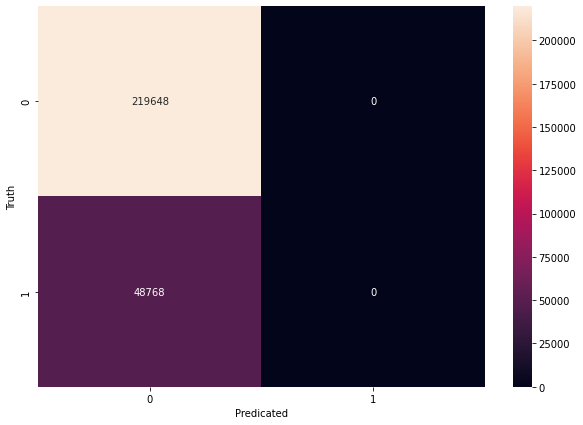

In [ ]:
preds = model1.predict(x_test)
cm = tf.math.confusion_matrix(labels=y_test,predictions=preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicated')
plt.ylabel('Truth')

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model1, tree_idx=0, max_depth=3)

In [ ]:
model1.make_inspector().features()

["data:0.0" (1; #0),
 "data:0.1" (1; #1),
 "data:0.2" (1; #2),
 "data:0.3" (1; #3)]

In [ ]:
model1.make_inspector().variable_importances()

{'MEAN_MIN_DEPTH': [("__LABEL" (4; #4), 6.9528727637458045),
  ("data:0.1" (1; #1), 5.836930074667347),
  ("data:0.0" (1; #0), 4.660334775724733),
  ("data:0.2" (1; #2), 2.234418224080396),
  ("data:0.3" (1; #3), 0.4084199668344952)],
 'NUM_AS_ROOT': [("data:0.3" (1; #3), 219.0), ("data:0.2" (1; #2), 81.0)],
 'NUM_NODES': [("data:0.3" (1; #3), 10707.0),
  ("data:0.0" (1; #0), 1864.0),
  ("data:0.2" (1; #2), 1192.0),
  ("data:0.1" (1; #1), 722.0)],
 'SUM_SCORE': [("data:0.3" (1; #3), 342597295.2277448),
  ("data:0.2" (1; #2), 522517.6588834489),
  ("data:0.0" (1; #0), 275406.3313518614),
  ("data:0.1" (1; #1), 54181.845337143255)]}

In [ ]:
model1.make_inspector().training_logs()

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=888893, accuracy=0.9999943750260155, loss=0.000202744602448273, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=7, evaluation=Evaluation(num_examples=2318375, accuracy=0.9999918046045182, loss=0.00015115527424869134, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=13, evaluation=Evaluation(num_examples=2409552, accuracy=0.9999941897912973, loss=5.797834348520313e-05, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=19, evaluation=Evaluation(num_examples=2415372, accuracy=0.9999946178062841, loss=4.2363091456181435e-05, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=24, evaluation=Evaluation(num_examples=2415701, accuracy=0.9999942045807821, loss=3.8798192920527125e-05, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=28, evaluation=Evaluation(num_examples=2415739, accuracy=0.999995446527

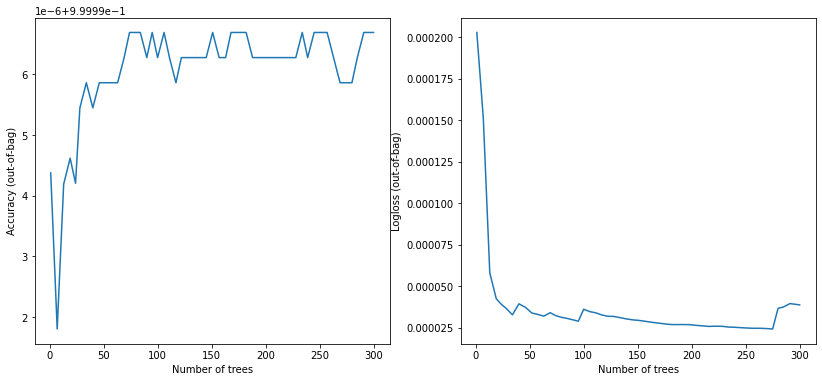

In [ ]:
import matplotlib.pyplot as plt

logs = model1.make_inspector().training_logs()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [ ]:
# This cell start TensorBoard that can be slow.
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Google internal version
# %load_ext google3.learning.brain.tensorboard.notebook.extension

In [ ]:
model1.make_inspector().export_to_tensorboard("/tmp/tensorboard_logs")

In [ ]:
%tensorboard --logdir "/tmp/tensorboard_logs"

<IPython.core.display.Javascript object>

In [ ]:
# print("Random Fores Score at testing: ",model1.score(x_test, y_test))
# print("Random Fores Score at testing: ",model1.score(x_train, y_train))

## Gardient Boosted Trees Model

In [ ]:
tuner = tfdf.tuner.RandomSearch(num_trials=20)
model2 = tfdf.keras.GradientBoostedTreesModel(tuner=tuner,random_seed=18)

model2.fit(x_train,y_train)

Use /tmp/tmpsz4sah5g as temporary training directory
Reading training dataset...
Training dataset read in 0:01:00.782806. Found 2415744 examples.
Training model...
Model trained in 0:17:23.815370
Compiling model...
Model compiled.


In [ ]:
model2.compile(metrics=["accuracy"])
evaluation = model2.evaluate(x_test,y_test,return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

8388/8388 [==============================] - 20s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000

loss: 0.0000
accuracy: 1.0000


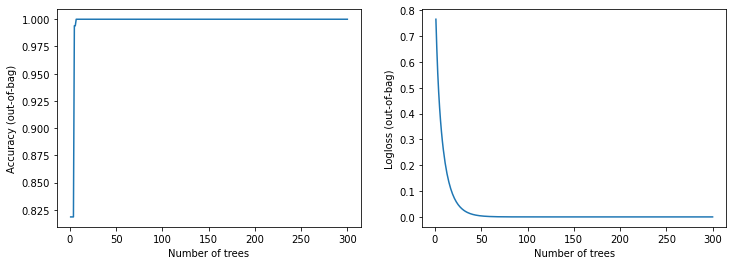

In [ ]:
import matplotlib.pyplot as plt

logs = model2.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [ ]:
model2.make_inspector().export_to_tensorboard("/tmp/tensorboard2_logs")

In [ ]:
%tensorboard --logdir "/tmp/tensorboard2_logs"

<IPython.core.display.Javascript object>

In [ ]:
model2.evaluate(x_test,y_test)

8388/8388 [==============================] - 20s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 0.9999962449073792]

In [ ]:
model2.predict(x_test)

8388/8388 [==============================] - 16s 2ms/step


array([[5.8095606e-10],
       [5.8095606e-10],
       [1.1698649e-09],
       ...,
       [5.8095606e-10],
       [2.5126687e-10],
       [2.5126687e-10]], dtype=float32)

In [ ]:
preds2 = model2.predict(x_test)
cm2 = tf.math.confusion_matrix(labels=y_test,predictions=preds2)
plt.figure(figsize=(10,7))
sns.heatmap(cm2,annot=True,fmt='d')
plt.xlabel('Predicated')
plt.ylabel('Truth')

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model2, tree_idx=0, max_depth=3)

In [ ]:
model2.make_inspector().features()

In [ ]:
model2.make_inspector().variable_importances()

## Score Fusion